In [1]:
import jax
import jax.numpy as jnp
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
from jax.example_libraries.optimizers import adamax as optimizer
# jax.config.update('jax_platform_name', 'cpu')
# jax.config.update('jax_disable_jit', True)

In [2]:
MB = 2 ** 12
NN_SHAPES = jnp.array([128, 128, 128, 128])
SCALE = 0.1
INIT_KEYS = jax.random.split(jax.random.PRNGKey(1), 8)

BETA = 0.8
MAX_AGE = 2.
MIN_DP = 0.2
INTEREST = 0.5
UTILITY_CONSTANT = 10.

R = (1 + INTEREST)
BR = BETA * R
OBJECTIVE_FN = lambda x, t: jax.lax.select((jnp.where(t == 1, size=1)[0] == 2)[0], 
                                           jnp.array([jnp.log(R * x), R * x, 0., 1.]), 
                                           jax.lax.select((jnp.where(t == 1, size=1)[0] == 1)[0], 
                                                          jnp.array([jnp.log((R * x) / (1 + BR)) + BETA * jnp.log((BR * (R * x)) / (1 + BR)), 
                                                                     ((R * x) / (1 + BR)), ((BR * (R * x))/(1 + BR)), 1.]), 
                                                          jnp.array([jnp.log((R * x) / (1 + BR + BR**2)) +\
                                                                     BETA * jnp.log((BR * (R * x))/(1 + BR + BR**2)) +\
                                                                     BETA**2 * jnp.log((BR**2 * (R * x))/(1 + BR + BR **2)),
                                                                     (R * x) / (1 + BR + BR**2),
                                                                     (R * x) - ((R * x) / (1 + BR + BR**2)),
                                                                     1.])))

In [3]:
initializer = jax.nn.initializers.glorot_normal()
w0 = SCALE * initializer(INIT_KEYS[0], (6, NN_SHAPES[0]), jnp.float32)
w1 = SCALE * initializer(INIT_KEYS[1], (NN_SHAPES[0], NN_SHAPES[1]), jnp.float32)
w2 = SCALE * initializer(INIT_KEYS[2], (NN_SHAPES[1], NN_SHAPES[2]), jnp.float32)
w3 = SCALE * initializer(INIT_KEYS[3], (NN_SHAPES[2] + 7, NN_SHAPES[3]), jnp.float32)
wf = SCALE * initializer(INIT_KEYS[4], (NN_SHAPES[3], 1), jnp.float32)
b0 = SCALE * initializer(INIT_KEYS[5], (1, NN_SHAPES[0]), jnp.float32)
b1 = SCALE * initializer(INIT_KEYS[6], (1, NN_SHAPES[1]), jnp.float32)
b2 = SCALE * initializer(INIT_KEYS[7], (1, NN_SHAPES[2]), jnp.float32)
b3 = SCALE * initializer(INIT_KEYS[8], (1, NN_SHAPES[3]), jnp.float32)
bf = SCALE * initializer(INIT_KEYS[9], (1, 1), jnp.float32)
params0 = {'w0': w0, 'w1': w1, 'w2': w2, 'vw3': w3, 'cw3': w3, 'vwf': wf, 'cwf': wf, 
           'b0': b0, 'b1': b1, 'b2': b2, 'vb3': b3, 'cb3': b3, 'vbf': bf, 'cbf': bf}

In [4]:
@jax.jit
def linear(X, w, b):
    return jnp.dot(X, w) + b


@jax.jit
def custom_value_fn(X, w, b):
    x = linear(X, w, b) / 100.
    return ((jnp.int32(x > 1) * (jnp.log(jnp.abs(x)) + 1)) +
           (jnp.int32(x < -1) * (-1 * (1/2)*jnp.power(x, 2) - (1/2))) +
           (jnp.int32(x <= 1) * jnp.int32(x >= -1) * x))


@jax.jit
def relu(X, w, b):
    return jnp.maximum(linear(X, w, b), 0)


@jax.jit
def selu(X, w, b):
    return jax.nn.selu(linear(X, w, b))


@jax.jit
def celu(X, w, b):
    return jax.nn.celu(linear(X, w, b))


@jax.jit
def elu(X, w, b):
    return jax.nn.elu(linear(X, w, b), 5)


@jax.jit
def cosine_output(X, w, b):
    return (jnp.cos(linear(X, w, b) / 1000) + 1) / 2


@jax.jit
def tanh_output(X, w, b):
    return (jax.nn.tanh(linear(X, w, b) / 1000) + 1) / 2


@jax.jit
def sigmoid_output(X, w, b):
    return jax.nn.sigmoid(linear(X, w, b) / 1e6)


@jax.jit
def increment_t(t):
    i = jnp.where(t == 1, size=1)[0]
    return t.at[i].set(0).at[i+1].set(1)


@jax.jit
def neural_network(params, x, t, o):
    x += o * INTEREST * x # If the agent is an owner, collect interest on savings
    po = (1 - o) * jnp.int32(x >= MIN_DP) * jnp.int32((jnp.where(t == 1, size=1)[0] < MAX_AGE))
    
    l0 = jnp.concatenate((x[jnp.newaxis], o[jnp.newaxis], t))
    l1 = relu(l0, params['w0'], params['b0'])
    l2 = relu(l1, params['w1'], params['b1'])
    l3 = jnp.squeeze(relu(l2, params['w2'], params['b2']))
    
    cl0 = jnp.concatenate((l0, po))
    cl3 = relu(jnp.concatenate((cl0, l3)), params['cw3'], params['cb3'])
    cu = x * sigmoid_output(cl3, params['cwf'], params['cbf'])
    c = jnp.select((jnp.where(t == 1, size=1)[0] >= MAX_AGE), x[jnp.newaxis], cu)
    
    o1 = jnp.squeeze(jnp.minimum(o + jnp.int32(x - c >= MIN_DP), 1.)) # If the agent saves enough they can become an owner
    
    vl0 = jnp.concatenate((l0, o1[jnp.newaxis]))
    vl3 = relu(jnp.concatenate((vl0, l3)), params['vw3'], params['vb3'])
    vu = custom_value_fn(vl3, params['vwf'], params['vbf'])
    v = jnp.select((jnp.where(t == 1, size=1)[0] > MAX_AGE), jnp.zeros(1), vu)
    
    return jnp.concatenate((v.reshape(-1), c.reshape(-1), (x - c).reshape(-1), o1.reshape(-1)))


@jax.jit
def loss(params, x, t, o):
    v0, c0, x1, o1 = neural_network(params, x, t, o)
    v1, c1, x2, o2 = neural_network(params, x1, increment_t(t), o1)
    
    vf = lambda params, x, t, o: neural_network(params, x, t, o)[0]
    v1r = vf(params, x1, increment_t(t), 0.)
    v1o = vf(params, x1, increment_t(t), 1.)
    v_diff = v1o - v1r
    
    c0x = jax.grad(lambda x: neural_network(params, x, t, o)[1])(x)
    v0x = jax.grad(vf, (1))(params, x, t, o)
    v1x = jax.grad(vf, (1))(params, x1, increment_t(t), o1)
    
    loss_bellman = ((UTILITY_CONSTANT * jnp.log(c0) + BETA * v1) - v0)
    loss_foc = BETA * (1 + o1 * INTEREST) * v1x * c0 - 1
    loss_envelope = (c0x - v0x * c0)
    
    return jnp.array([loss_bellman, loss_foc, loss_envelope])


@jax.jit
def batch_loss(params, xs, ts, os, W=jnp.diag(jnp.ones(3))):
    losses = jax.vmap(loss, in_axes=(None, 0, 0, 0))(params, xs, ts, os)
    return  jnp.mean(jax.vmap(lambda l: l @ W @ l.T)(losses)), tuple((jnp.mean(losses[:, 0]**2), jnp.mean(losses[:, 1]**2), jnp.mean(losses[:, 2]**2)))

In [5]:
all_X = jnp.concatenate((jnp.linspace(1e-5, 1., 1000), jnp.linspace(1e-5, 1., 1000),
                         jnp.linspace(1e-5, 1., 1000), jnp.linspace(1e-5, 1., 1000), 
                         jnp.linspace(1e-5, 1., 1000), jnp.linspace(1e-5, 1., 1000)))
all_T = jax.nn.one_hot(jnp.concatenate((jnp.zeros(1000), jnp.ones(1000), 2 * jnp.ones(1000), 
                         jnp.zeros(1000), jnp.ones(1000), 2 * jnp.ones(1000))), 4)
all_O = jnp.concatenate((jnp.zeros(1000), jnp.zeros(1000), jnp.zeros(1000),
                         jnp.ones(1000), jnp.ones(1000), jnp.ones(1000)))


def training_loop(X, T, O, opt_state, opt_update, get_params, W=jnp.diag(jnp.ones(3)), max_iter=1000):
    j = 0
    key = jax.random.PRNGKey(1)
    keys = jax.random.split(key, max_iter)
    
    best_opt_state = opt_state
    best_loss, _ = batch_loss(get_params(best_opt_state), all_X, all_T, all_O)

    while j < max_iter:
        key = keys[j]
        sample = jax.random.choice(key, jnp.arange(X.shape[0]), (3, MB))
        params = get_params(opt_state)

        (val_loss, (loss_bellman, loss_foc, loss_envelope)), grad = jax.value_and_grad(batch_loss, has_aux=True)(get_params(opt_state), X[sample[0]], T[sample[1]], O[sample[2]], W=W)
        
        if any([jnp.isnan(v).any() for v in params.values()]) or any([jnp.isnan(v).any() for v in grad.values()]):
            print(f'Encountered a NaN in iteration {j}, terminating ...')
            print(params)
            print(grad)
            break
        
        opt_state = opt_update(j, grad, opt_state)
        
        if j == 0:
            start_time = time.time()
        
        j += 1
        if j % 100 == 0:
            fair_loss, _ = batch_loss(params, all_X, all_T, all_O)
            if fair_loss < best_loss:
                best_opt_state = opt_state
                best_loss = fair_loss
            print(f'Iteration: {j}\tCurrent Loss: {val_loss:.2f}\tFair Loss: {fair_loss:.2f}\tAverage samples/s: {((MB * j) / (time.time() - start_time)):.2f}\n'
                  f'Loss Bellman: {loss_bellman:.2f}\tLoss FoC: {loss_foc:.2f}\tLoss Envelope: {loss_envelope:.2f}')
        
    return opt_state, best_opt_state

In [15]:
opt_init, opt_update, get_params = optimizer(step_size=1e-2)
init_opt_state = opt_init(params0)
X = jnp.linspace(1e-5, 1., 1000)
T = jax.nn.one_hot(jnp.concatenate((jnp.zeros(333), jnp.ones(333), 2 * jnp.ones(334))), 4)
O = jnp.concatenate((jnp.zeros(500), jnp.ones(500)))
W = jnp.diag(jnp.array([1., 1., 1.]))
if 'best_opt_state' not in globals():
    opt_state = init_opt_state
else:
    opt_state = best_opt_state

current_opt_state, best_opt_state = training_loop(X, T, O, init_opt_state, opt_update, get_params, W=W, max_iter=20000)

Iteration: 100	Current Loss: 97.81	Fair Loss: 99.40	Average samples/s: 57708.43
Loss Bellman: 90.01	Loss FoC: 3.16	Loss Envelope: 4.64
Iteration: 200	Current Loss: 99.06	Fair Loss: 98.56	Average samples/s: 57003.07
Loss Bellman: 90.80	Loss FoC: 3.35	Loss Envelope: 4.91
Iteration: 300	Current Loss: 81.01	Fair Loss: 97.68	Average samples/s: 57283.00
Loss Bellman: 72.84	Loss FoC: 3.27	Loss Envelope: 4.90
Iteration: 400	Current Loss: 91.30	Fair Loss: 96.41	Average samples/s: 56952.15
Loss Bellman: 82.79	Loss FoC: 3.43	Loss Envelope: 5.09
Iteration: 500	Current Loss: 82.37	Fair Loss: 94.96	Average samples/s: 56426.86
Loss Bellman: 73.79	Loss FoC: 3.41	Loss Envelope: 5.17
Iteration: 600	Current Loss: 95.58	Fair Loss: 93.17	Average samples/s: 56235.97
Loss Bellman: 86.89	Loss FoC: 3.45	Loss Envelope: 5.24
Iteration: 700	Current Loss: 83.63	Fair Loss: 91.09	Average samples/s: 56198.16
Loss Bellman: 76.02	Loss FoC: 3.04	Loss Envelope: 4.57
Iteration: 800	Current Loss: 94.99	Fair Loss: 88.74	Ave

Iteration: 6200	Current Loss: 79.72	Fair Loss: 80.63	Average samples/s: 56531.15
Loss Bellman: 73.12	Loss FoC: 2.53	Loss Envelope: 4.07
Iteration: 6300	Current Loss: 71.47	Fair Loss: 80.36	Average samples/s: 56531.57
Loss Bellman: 64.99	Loss FoC: 2.46	Loss Envelope: 4.02
Iteration: 6400	Current Loss: 78.32	Fair Loss: 80.50	Average samples/s: 56533.78
Loss Bellman: 70.54	Loss FoC: 2.88	Loss Envelope: 4.90
Iteration: 6500	Current Loss: 81.48	Fair Loss: 80.39	Average samples/s: 56547.65
Loss Bellman: 74.31	Loss FoC: 2.76	Loss Envelope: 4.40
Iteration: 6600	Current Loss: 86.58	Fair Loss: 80.32	Average samples/s: 56539.76
Loss Bellman: 80.82	Loss FoC: 2.20	Loss Envelope: 3.56
Iteration: 6700	Current Loss: 79.96	Fair Loss: 80.20	Average samples/s: 56546.77
Loss Bellman: 72.06	Loss FoC: 3.00	Loss Envelope: 4.90
Iteration: 6800	Current Loss: 80.50	Fair Loss: 80.05	Average samples/s: 56541.62
Loss Bellman: 74.37	Loss FoC: 2.29	Loss Envelope: 3.85
Iteration: 6900	Current Loss: 78.16	Fair Loss: 8

Iteration: 12300	Current Loss: 28.35	Fair Loss: 35.60	Average samples/s: 56297.33
Loss Bellman: 19.97	Loss FoC: 0.61	Loss Envelope: 7.77
Iteration: 12400	Current Loss: 28.03	Fair Loss: 35.60	Average samples/s: 56300.35
Loss Bellman: 21.13	Loss FoC: 0.61	Loss Envelope: 6.30
Iteration: 12500	Current Loss: 37.70	Fair Loss: 35.72	Average samples/s: 56289.07
Loss Bellman: 30.77	Loss FoC: 0.63	Loss Envelope: 6.31
Iteration: 12600	Current Loss: 33.23	Fair Loss: 34.49	Average samples/s: 56293.79
Loss Bellman: 26.26	Loss FoC: 0.63	Loss Envelope: 6.34
Iteration: 12700	Current Loss: 32.74	Fair Loss: 35.91	Average samples/s: 56287.83
Loss Bellman: 24.58	Loss FoC: 0.63	Loss Envelope: 7.53
Iteration: 12800	Current Loss: 30.35	Fair Loss: 34.17	Average samples/s: 56279.78
Loss Bellman: 22.91	Loss FoC: 0.64	Loss Envelope: 6.80
Iteration: 12900	Current Loss: 38.59	Fair Loss: 34.28	Average samples/s: 56282.36
Loss Bellman: 29.96	Loss FoC: 0.63	Loss Envelope: 7.99
Iteration: 13000	Current Loss: 37.67	Fair

Iteration: 18300	Current Loss: 29.48	Fair Loss: 30.99	Average samples/s: 56112.27
Loss Bellman: 20.95	Loss FoC: 0.88	Loss Envelope: 7.65
Iteration: 18400	Current Loss: 25.59	Fair Loss: 31.07	Average samples/s: 56111.84
Loss Bellman: 17.33	Loss FoC: 0.88	Loss Envelope: 7.38
Iteration: 18500	Current Loss: 28.70	Fair Loss: 30.91	Average samples/s: 56108.16
Loss Bellman: 20.47	Loss FoC: 0.89	Loss Envelope: 7.34
Iteration: 18600	Current Loss: 32.45	Fair Loss: 31.21	Average samples/s: 56105.20
Loss Bellman: 24.65	Loss FoC: 0.90	Loss Envelope: 6.90
Iteration: 18700	Current Loss: 31.01	Fair Loss: 31.07	Average samples/s: 56109.52
Loss Bellman: 23.13	Loss FoC: 0.90	Loss Envelope: 6.98
Iteration: 18800	Current Loss: 32.45	Fair Loss: 30.76	Average samples/s: 56106.66
Loss Bellman: 24.81	Loss FoC: 0.90	Loss Envelope: 6.74
Iteration: 18900	Current Loss: 36.64	Fair Loss: 31.20	Average samples/s: 56102.07
Loss Bellman: 28.77	Loss FoC: 0.91	Loss Envelope: 6.96
Iteration: 19000	Current Loss: 29.87	Fair

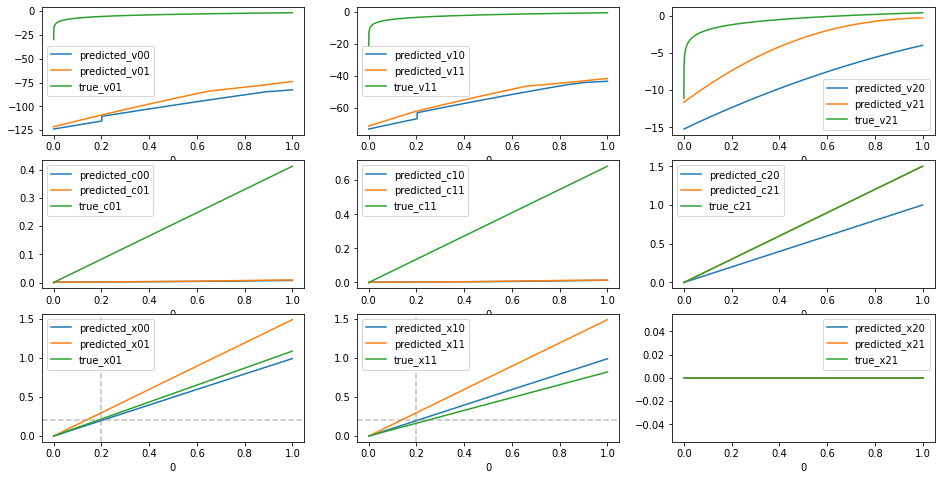

In [16]:
params = get_params(best_opt_state)

init00 = jax.vmap(neural_network, in_axes=(None, 0, None, None))(params0, X, jnp.array([1., 0., 0., 0.]), 0.)
pred00 = jax.vmap(neural_network, in_axes=(None, 0, None, None))(params, X, jnp.array([1., 0., 0., 0.]), 0.)

init10 = jax.vmap(neural_network, in_axes=(None, 0, None, None))(params0, X, jnp.array([0., 1., 0., 0.]), 0.)
pred10 = jax.vmap(neural_network, in_axes=(None, 0, None, None))(params, X, jnp.array([0., 1., 0., 0.]), 0.)

init20 = jax.vmap(neural_network, in_axes=(None, 0, None, None))(params0, X, jnp.array([0., 0., 1., 0.]), 0.)
pred20 = jax.vmap(neural_network, in_axes=(None, 0, None, None))(params, X, jnp.array([0., 0., 1., 0.]), 0.)

init01 = jax.vmap(neural_network, in_axes=(None, 0, None, None))(params0, X, jnp.array([1., 0., 0., 0.]), 1.)
pred01 = jax.vmap(neural_network, in_axes=(None, 0, None, None))(params, X, jnp.array([1., 0., 0., 0.]), 1.)
true01 = jax.vmap(OBJECTIVE_FN, in_axes=(0, None))(X, jnp.array([1., 0., 0., 0.]))

init11 = jax.vmap(neural_network, in_axes=(None, 0, None, None))(params0, X, jnp.array([0., 1., 0., 0.]), 1.)
pred11 = jax.vmap(neural_network, in_axes=(None, 0, None, None))(params, X, jnp.array([0., 1., 0., 0.]), 1.)
true11 = jax.vmap(OBJECTIVE_FN, in_axes=(0, None))(X, jnp.array([0., 1., 0., 0.]))
                                                                 
init21 = jax.vmap(neural_network, in_axes=(None, 0, None, None))(params0, X, jnp.array([0., 0., 1., 0.]), 1.)
pred21 = jax.vmap(neural_network, in_axes=(None, 0, None, None))(params, X, jnp.array([0., 0., 1., 0.]), 1.)
true21 = jax.vmap(OBJECTIVE_FN, in_axes=(0, None))(X, jnp.array([0., 0., 1., 0.]))

                                                                 
df = pd.DataFrame(jnp.concatenate((X.reshape(-1, 1), 
                                   init00, pred00, init10, pred10, init20, pred20,
                                   init01, pred01, init11, pred11, init21, pred21,
                                   true01, true11, true21), 
                                  axis=1)).set_index(0)
df.columns = ['initial_v00', 'initial_c00', 'initial_x00', 'initial_o10', 'predicted_v00', 'predicted_c00', 'predicted_x00', 'predicted_o10',
              'initial_v10', 'initial_c10', 'initial_x10', 'initial_o20', 'predicted_v10', 'predicted_c10', 'predicted_x10', 'predicted_o20', 
              'initial_v20', 'initial_c20', 'initial_x20', 'initial_o30', 'predicted_v20', 'predicted_c20', 'predicted_x20', 'predicted_o30',
              'initial_v01', 'initial_c01', 'initial_x00', 'initial_o11', 'predicted_v01', 'predicted_c01', 'predicted_x01', 'predicted_o11',
              'initial_v11', 'initial_c11', 'initial_x11', 'initial_o21', 'predicted_v11', 'predicted_c11', 'predicted_x11', 'predicted_o21', 
              'initial_v21', 'initial_c21', 'initial_x21', 'initial_o31', 'predicted_v21', 'predicted_c21', 'predicted_x21', 'predicted_o31',
              'true_v01', 'true_c01', 'true_x01', 'true_011',
              'true_v11', 'true_c11', 'true_x11', 'true_021',
              'true_v21', 'true_c21', 'true_x21', 'true_031']

fig, axes = plt.subplots(3, 3, figsize=(16, 8))
df.plot(y=['predicted_v00'], ax=axes.flatten()[0])
df.plot(y=['predicted_v10'], ax=axes.flatten()[1])
df.plot(y=['predicted_v20'], ax=axes.flatten()[2])
df.plot(y=['predicted_v01'], ax=axes.flatten()[0])
df.plot(y=['predicted_v11'], ax=axes.flatten()[1])
df.plot(y=['predicted_v21'], ax=axes.flatten()[2])
df.plot(y=['predicted_c00'], ax=axes.flatten()[3])
df.plot(y=['predicted_c10'], ax=axes.flatten()[4])
df.plot(y=['predicted_c20'], ax=axes.flatten()[5])
df.plot(y=['predicted_c01'], ax=axes.flatten()[3])
df.plot(y=['predicted_c11'], ax=axes.flatten()[4])
df.plot(y=['predicted_c21'], ax=axes.flatten()[5])
df.plot(y=['predicted_x00'], ax=axes.flatten()[6])
df.plot(y=['predicted_x10'], ax=axes.flatten()[7])
df.plot(y=['predicted_x20'], ax=axes.flatten()[8])
df.plot(y=['predicted_x01'], ax=axes.flatten()[6])
df.plot(y=['predicted_x11'], ax=axes.flatten()[7])
df.plot(y=['predicted_x21'], ax=axes.flatten()[8])                                     
df.plot(y=['true_v01'], ax=axes.flatten()[0])
df.plot(y=['true_v11'], ax=axes.flatten()[1])
df.plot(y=['true_v21'], ax=axes.flatten()[2])
df.plot(y=['true_c01'], ax=axes.flatten()[3])
df.plot(y=['true_c11'], ax=axes.flatten()[4])
df.plot(y=['true_c21'], ax=axes.flatten()[5])
df.plot(y=['true_x01'], ax=axes.flatten()[6])
df.plot(y=['true_x11'], ax=axes.flatten()[7])
df.plot(y=['true_x21'], ax=axes.flatten()[8])
                                                   
for ax in axes.flatten()[6:8]:
    ax.axhline(y=MIN_DP, color='grey', linestyle='--', alpha=0.5)
    ax.axvline(x=MIN_DP, color='grey', linestyle='--', alpha=0.5)

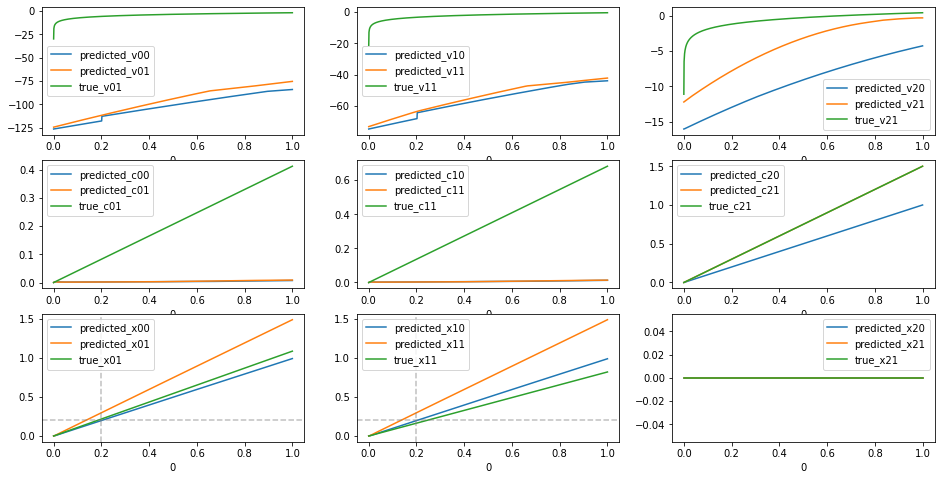

In [8]:
params = get_params(current_opt_state)

init00 = jax.vmap(neural_network, in_axes=(None, 0, None, None))(params0, X, jnp.array([1., 0., 0., 0.]), 0.)
pred00 = jax.vmap(neural_network, in_axes=(None, 0, None, None))(params, X, jnp.array([1., 0., 0., 0.]), 0.)

init10 = jax.vmap(neural_network, in_axes=(None, 0, None, None))(params0, X, jnp.array([0., 1., 0., 0.]), 0.)
pred10 = jax.vmap(neural_network, in_axes=(None, 0, None, None))(params, X, jnp.array([0., 1., 0., 0.]), 0.)

init20 = jax.vmap(neural_network, in_axes=(None, 0, None, None))(params0, X, jnp.array([0., 0., 1., 0.]), 0.)
pred20 = jax.vmap(neural_network, in_axes=(None, 0, None, None))(params, X, jnp.array([0., 0., 1., 0.]), 0.)

init01 = jax.vmap(neural_network, in_axes=(None, 0, None, None))(params0, X, jnp.array([1., 0., 0., 0.]), 1.)
pred01 = jax.vmap(neural_network, in_axes=(None, 0, None, None))(params, X, jnp.array([1., 0., 0., 0.]), 1.)
true01 = jax.vmap(OBJECTIVE_FN, in_axes=(0, None))(X, jnp.array([1., 0., 0., 0.]))

init11 = jax.vmap(neural_network, in_axes=(None, 0, None, None))(params0, X, jnp.array([0., 1., 0., 0.]), 1.)
pred11 = jax.vmap(neural_network, in_axes=(None, 0, None, None))(params, X, jnp.array([0., 1., 0., 0.]), 1.)
true11 = jax.vmap(OBJECTIVE_FN, in_axes=(0, None))(X, jnp.array([0., 1., 0., 0.]))
                                                                 
init21 = jax.vmap(neural_network, in_axes=(None, 0, None, None))(params0, X, jnp.array([0., 0., 1., 0.]), 1.)
pred21 = jax.vmap(neural_network, in_axes=(None, 0, None, None))(params, X, jnp.array([0., 0., 1., 0.]), 1.)
true21 = jax.vmap(OBJECTIVE_FN, in_axes=(0, None))(X, jnp.array([0., 0., 1., 0.]))

                                                                 
df = pd.DataFrame(jnp.concatenate((X.reshape(-1, 1), 
                                   init00, pred00, init10, pred10, init20, pred20,
                                   init01, pred01, init11, pred11, init21, pred21,
                                   true01, true11, true21), 
                                  axis=1)).set_index(0)
df.columns = ['initial_v00', 'initial_c00', 'initial_x00', 'initial_o10', 'predicted_v00', 'predicted_c00', 'predicted_x00', 'predicted_o10',
              'initial_v10', 'initial_c10', 'initial_x10', 'initial_o20', 'predicted_v10', 'predicted_c10', 'predicted_x10', 'predicted_o20', 
              'initial_v20', 'initial_c20', 'initial_x20', 'initial_o30', 'predicted_v20', 'predicted_c20', 'predicted_x20', 'predicted_o30',
              'initial_v01', 'initial_c01', 'initial_x00', 'initial_o11', 'predicted_v01', 'predicted_c01', 'predicted_x01', 'predicted_o11',
              'initial_v11', 'initial_c11', 'initial_x11', 'initial_o21', 'predicted_v11', 'predicted_c11', 'predicted_x11', 'predicted_o21', 
              'initial_v21', 'initial_c21', 'initial_x21', 'initial_o31', 'predicted_v21', 'predicted_c21', 'predicted_x21', 'predicted_o31',
              'true_v01', 'true_c01', 'true_x01', 'true_011',
              'true_v11', 'true_c11', 'true_x11', 'true_021',
              'true_v21', 'true_c21', 'true_x21', 'true_031']

fig, axes = plt.subplots(3, 3, figsize=(16, 8))
df.plot(y=['predicted_v00'], ax=axes.flatten()[0])
df.plot(y=['predicted_v10'], ax=axes.flatten()[1])
df.plot(y=['predicted_v20'], ax=axes.flatten()[2])
df.plot(y=['predicted_v01'], ax=axes.flatten()[0])
df.plot(y=['predicted_v11'], ax=axes.flatten()[1])
df.plot(y=['predicted_v21'], ax=axes.flatten()[2])
df.plot(y=['predicted_c00'], ax=axes.flatten()[3])
df.plot(y=['predicted_c10'], ax=axes.flatten()[4])
df.plot(y=['predicted_c20'], ax=axes.flatten()[5])
df.plot(y=['predicted_c01'], ax=axes.flatten()[3])
df.plot(y=['predicted_c11'], ax=axes.flatten()[4])
df.plot(y=['predicted_c21'], ax=axes.flatten()[5])
df.plot(y=['predicted_x00'], ax=axes.flatten()[6])
df.plot(y=['predicted_x10'], ax=axes.flatten()[7])
df.plot(y=['predicted_x20'], ax=axes.flatten()[8])
df.plot(y=['predicted_x01'], ax=axes.flatten()[6])
df.plot(y=['predicted_x11'], ax=axes.flatten()[7])
df.plot(y=['predicted_x21'], ax=axes.flatten()[8])                                     
df.plot(y=['true_v01'], ax=axes.flatten()[0])
df.plot(y=['true_v11'], ax=axes.flatten()[1])
df.plot(y=['true_v21'], ax=axes.flatten()[2])
df.plot(y=['true_c01'], ax=axes.flatten()[3])
df.plot(y=['true_c11'], ax=axes.flatten()[4])
df.plot(y=['true_c21'], ax=axes.flatten()[5])
df.plot(y=['true_x01'], ax=axes.flatten()[6])
df.plot(y=['true_x11'], ax=axes.flatten()[7])
df.plot(y=['true_x21'], ax=axes.flatten()[8])
                                                   
for ax in axes.flatten()[6:8]:
    ax.axhline(y=MIN_DP, color='grey', linestyle='--', alpha=0.5)
    ax.axvline(x=MIN_DP, color='grey', linestyle='--', alpha=0.5)

We should see that once starting wealth (x-axis) is above 0.4, it is possible for the renter to try and become a homeowner, so the savings function (x_00) should bend up to the horizontal grey line. Instead we see it stays completely linear, the renter is indifferent to becoming a homeowner, even though we have estimated correctly that the homeowner has a higher value.

In [9]:
losses = jax.vmap(loss, in_axes=(None, 0, 0, 0))(params, all_X, all_T, all_O)
jnp.mean(losses**2, axis=0)

DeviceArray([21.668737  ,  0.91536057,  7.9548783 ], dtype=float32)

In [10]:
batch_loss(params, all_X[0:1000], all_T[0:1000], all_O[0:1000])

(DeviceArray(4.9993443, dtype=float32),
 (DeviceArray(4.163244, dtype=float32),
  DeviceArray(0.8211396, dtype=float32),
  DeviceArray(0.01496185, dtype=float32)))

In [11]:
batch_loss(params, all_X[1000:2000], all_T[1000:2000], all_O[1000:2000])

(DeviceArray(5.0027485, dtype=float32),
 (DeviceArray(4.08633, dtype=float32),
  DeviceArray(0.8951772, dtype=float32),
  DeviceArray(0.0212408, dtype=float32)))

In [12]:
batch_loss(params, all_X[2000:3000], all_T[2000:3000], all_O[2000:3000])

(DeviceArray(81.40434, dtype=float32),
 (DeviceArray(58.031235, dtype=float32),
  DeviceArray(1., dtype=float32),
  DeviceArray(22.37311, dtype=float32)))

In [13]:
batch_loss(params, all_X[3000:4000], all_T[3000:4000], all_O[3000:4000])

(DeviceArray(4.253661, dtype=float32),
 (DeviceArray(3.3931992, dtype=float32),
  DeviceArray(0.8296725, dtype=float32),
  DeviceArray(0.0307905, dtype=float32)))

In [14]:
#     live_next = (t < MAX_AGE)
#     loss_euler = 0 # jax.lax.select(live_next, 
#                                 jax.lax.select(o == 1.,
#                                                1e2 * (c1 - ((BETA * (1 + INTEREST)) * c0)),
#                                                jax.lax.select(x1 >= MIN_DP,
#                                                               0.,
#                                                               # (BETA * c0 * (v1x + (v_diff / (MIN_DP - x1))) - 1))),
#                                                               # c1 - BETA * c0 * (1 + jnp.int32(jnp.isclose(x1, MIN_DP)) * v_diff * c1))), 
#                                                               # (c1 - BETA) * c0 + jnp.maximum(0, v_diff - (MIN_DP - x1) / c0))),
#                                                               (BETA * c0) - (c1 * (1 + BETA * c0 * jnp.int32(x1 + EPSILON > MIN_DP) * v_diff / EPSILON)))), 
#                                 0.)